In [57]:
import pandas as pd
import numpy as np


from datetime import timedelta

from warnings import filterwarnings
filterwarnings('ignore')
testing_models = True

In [58]:
data = pd.read_csv("../data/store_demand.csv")
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data['store_item'] = data.store.astype(str) + '-' + data.item.astype(str)
data.drop(['store', 'item'], axis=1, inplace=True)
data = data[data.store_item != '3-5'] # auto reg broke on this one check it if time permits
# note non unique indices


In [59]:
def train_test_splitter(df, pct=0.8):
    timespan = (df.index.max() - df.index.min()).days
    train_date = round(timespan*pct)
    train = df.index.min() + timedelta(days=train_date)
    return [df[df.index <= train], df[df.index > train]]


train, test = train_test_splitter(data, .7)


In [60]:
import matplotlib.pyplot as plt

%matplotlib inline


# for store in train.store_item.unique():
#     temp = train[train.store_item == store]
#     plt.figure()
#     plt.plot(temp.sales, "-b", label = "sales")
#     plt.legend(loc="upper left")
#     plt.title(f"store {store}")
#     plt.show()


In [61]:

# subset for testing

if testing_models:
    train = train[train.store_item.isin(['1-1', '1-2', '1-3'])]
    test = test[test.store_item.isin(['1-1', '1-2', '1-3'])]
else:
    from warnings import filterwarnings
    filterwarnings('ignore')


In [62]:
from statsmodels.tsa.ar_model import AutoReg

In [63]:
# generalize this a bit later, 
preds_autoreg = []
store_item = []
for series in train.store_item.unique(): 
    temp = train[train.store_item == series]
    
    model = AutoReg(temp.sales, lags=10, old_names=False, seasonal=True, period=365)
    model_fit = model.fit()
    try:
        yhat = model_fit.predict(len(temp), round((len(temp)*1/0.7) -2)) # find a less ratchet way
        # to make the prediction len match the testing set len
        preds_autoreg.append(yhat)
        item = np.repeat(series, len(yhat))
        store_item.append(item)
    except np.linalg.LinAlgError:
        print(f'series {series}')

In [64]:
dates = []
for item in preds_autoreg:
    for sub in item.index:
        dates.append(sub)

In [65]:
predictions = pd.DataFrame(
    {
        'store_item': [x for sub in store_item for x in sub],
        'sales': test.sales,
        'autoreg': [x for sub in preds_autoreg for x in sub]     
    }, index = dates
)

In [66]:
def model_fitter(df, mod):
    preds = []
    for series in df.store_item.unique():
        temp = train[train.store_item == series] 
        model_fit = model.fit()
        yhat = model_fit.predict(len(temp), round((len(temp)*1/0.7) -2))
        preds.append(yhat) 
    return [x for sub in preds for x in sub]

In [67]:
from statsmodels.tsa.arima.model import ARIMA

In [68]:
# TODO: fix these parameters
model = ARIMA(temp.sales, order=(0,0,1))
predictions["ma"] = model_fitter(train, mod=model)  

model = ARIMA(temp.sales, order=(2,0,1))
predictions["arma"] = model_fitter(train, mod=model)  

model = ARIMA(temp.sales, order=(1,1,1))
predictions["arima"] = model_fitter(train, mod=model)  

model = ARIMA(temp.sales, order=(1,1,1), seasonal_order=(0,0,0,0))
predictions["sarima"] = model_fitter(train, mod=model)  


In [69]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt


In [70]:
model = SimpleExpSmoothing(temp.sales, initialization_method="estimated")
predictions["sexpsmoothing"] = model_fitter(train, model)

In [71]:
model = ExponentialSmoothing(temp.sales)
predictions["expsmooth"] = model_fitter(train, model)

In [75]:
model = Holt(temp.sales, initialization_method="estimated")
predictions["holt"] = model_fitter(train, model)

Holt(livestock2, exponential=True, initialization_method="estimated")


In [76]:
store_sales = pd.concat([train, predictions])

In [77]:
predictions

,store_item,sales,autoreg,ma,arma,arima,sarima,sexpsmoothing,expsmooth,holt
2016-07-03,1-1,35,33.564926,31.322013,41.141345,41.620621,41.620621,42.605203,42.605203,43.648692
2016-07-04,1-1,18,25.371284,31.455427,41.787365,42.360943,42.360943,42.605203,42.605203,43.715954
2016-07-05,1-1,31,27.200800,31.455427,41.820865,42.443726,42.443726,42.605203,42.605203,43.783215
2016-07-06,1-1,22,28.000816,31.455427,41.786234,42.452983,42.452983,42.605203,42.605203,43.850477
2016-07-07,1-1,33,26.200584,31.455427,41.744166,42.454018,42.454018,42.605203,42.605203,43.917739
...,...,...,...,...,...,...,...,...,...,...
2017-12-27,1-3,26,17.333378,31.455427,32.519495,42.454148,42.454148,42.605203,42.605203,80.104463
2017-12-28,1-3,21,25.333375,31.455427,32.514917,42.454148,42.454148,42.605203,42.605203,80.171725
2017-12-29,1-3,38,19.000040,31.455427,32.510359,42.454148,42.454148,42.605203,42.605203,80.238986
2017-12-30,1-3,27,20.000037,31.455427,32.505819,42.454148,42.454148,42.605203,42.605203,80.306248


In [78]:

# store_1 = predictions[predictions.store_item == '1-1']
def fcastplotter(x):
        
    for store in store_sales.store_item.unique():
        temp = store_sales[store_sales.store_item == store]
        plt.figure()
        plt.plot(temp.sales, "-b", label = "sales")
        plt.plot(temp[x],  "-r", label = f"Forecast {x} ")
        plt.legend(loc="upper left")
        plt.ylim([0, None])
        plt.title(f"store {store}")
        plt.show()
        # # plt.plot(store_1.arima)

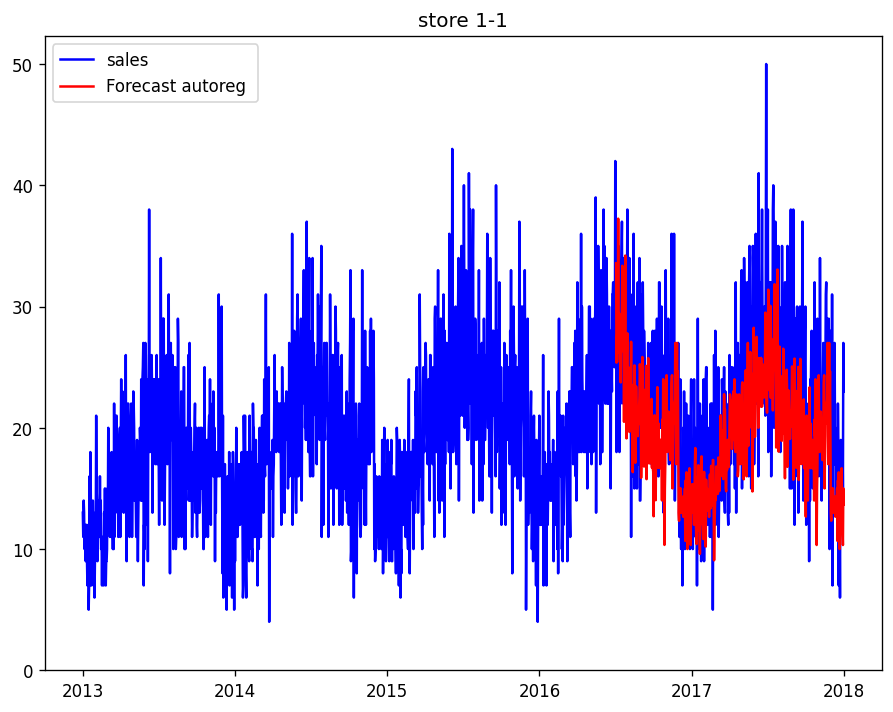

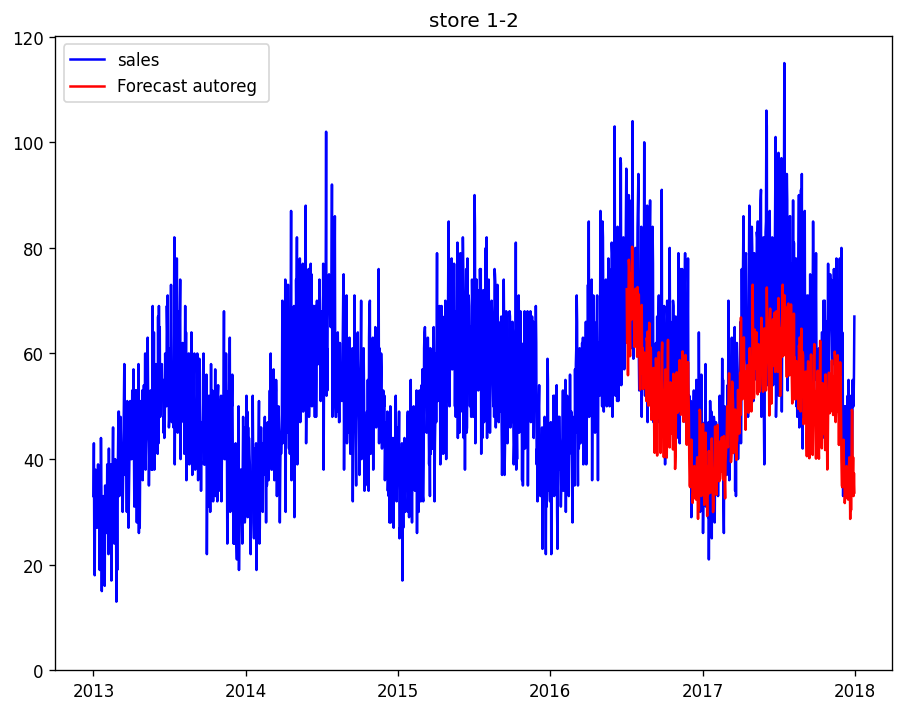

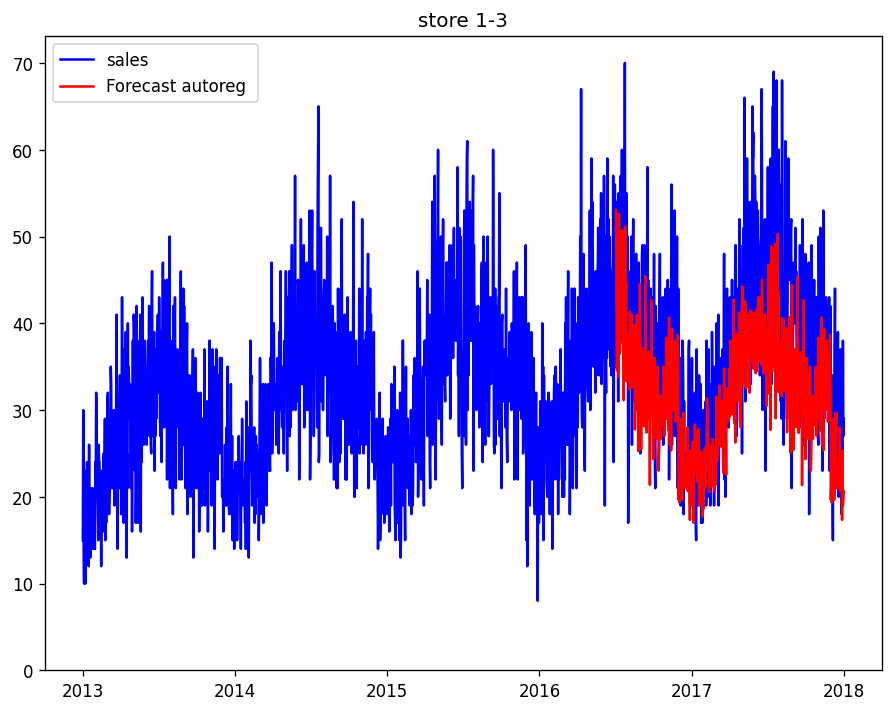

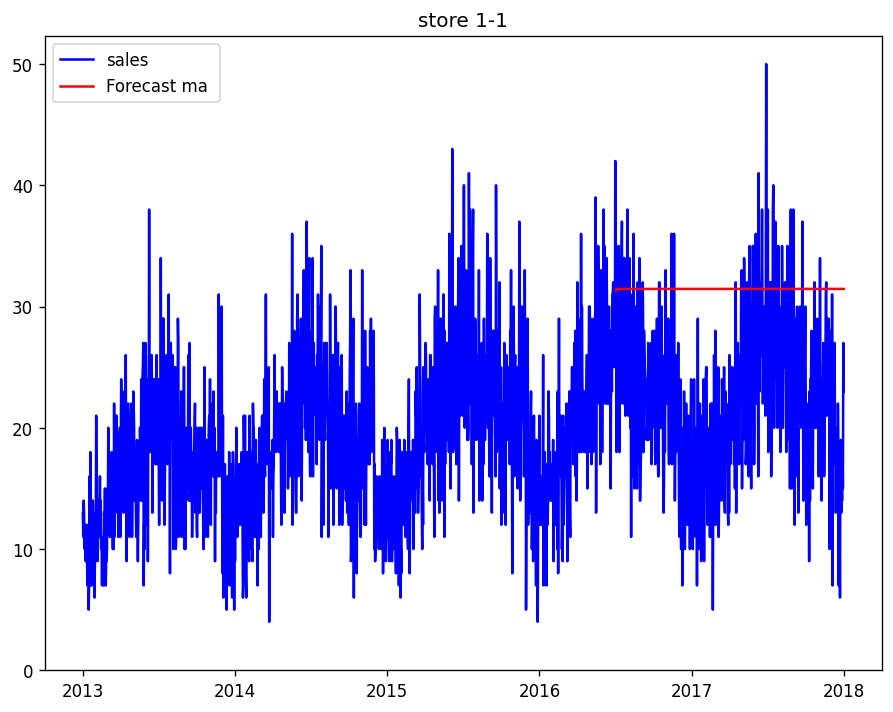

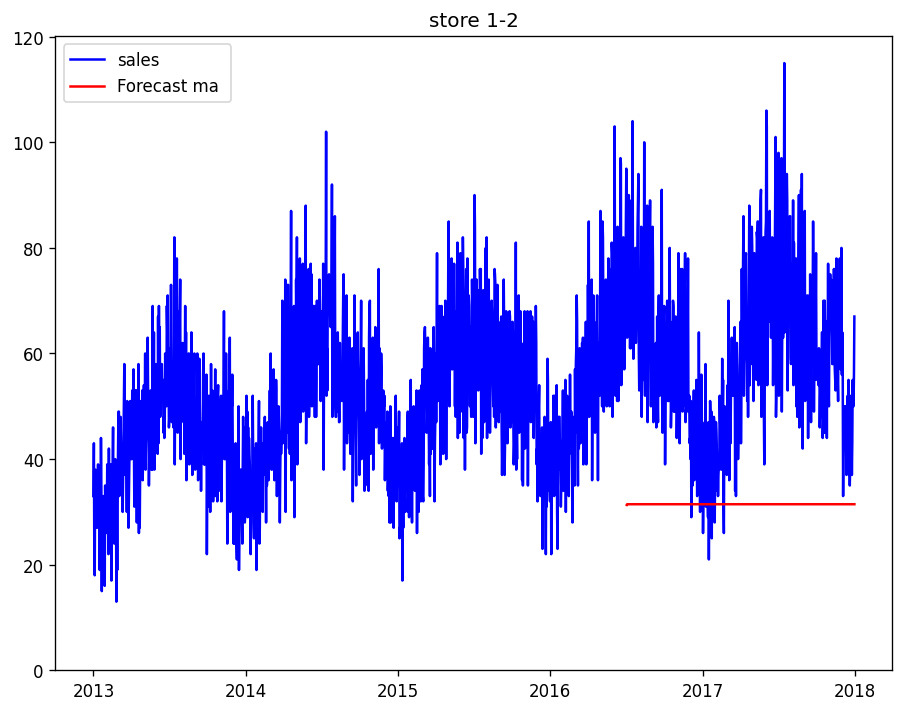

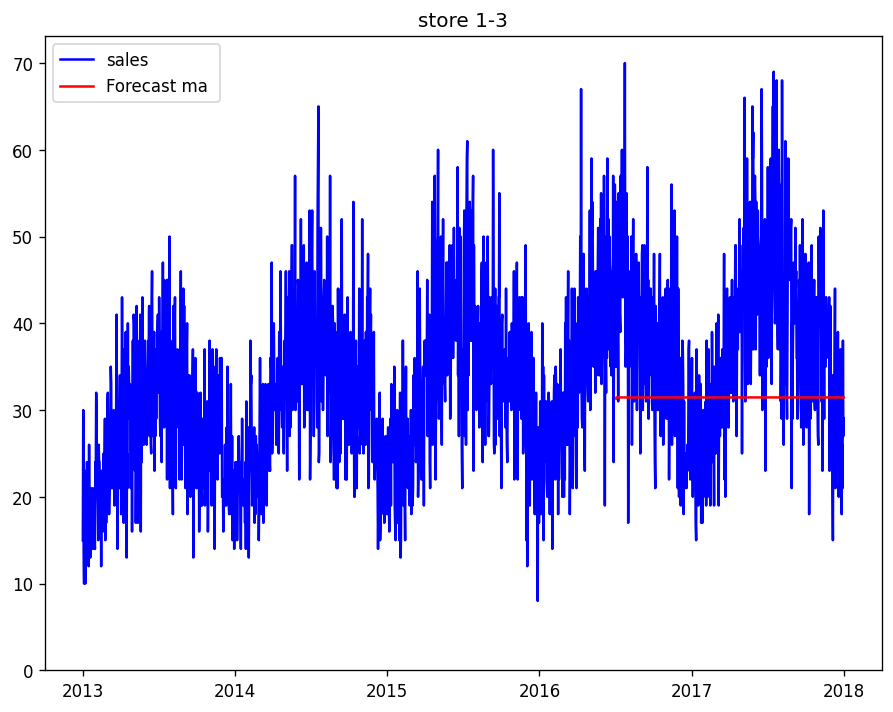

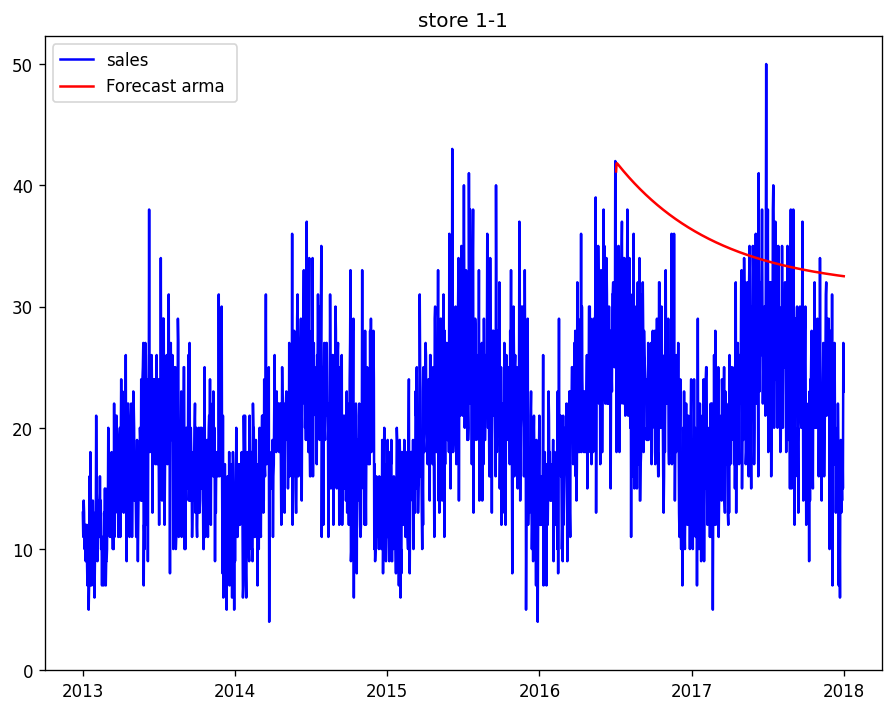

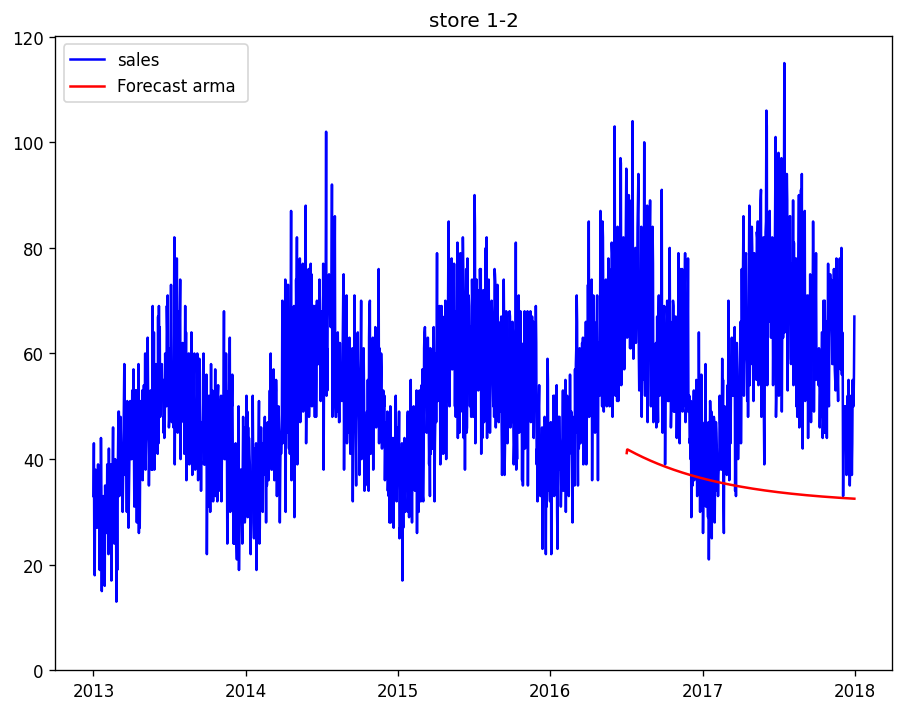

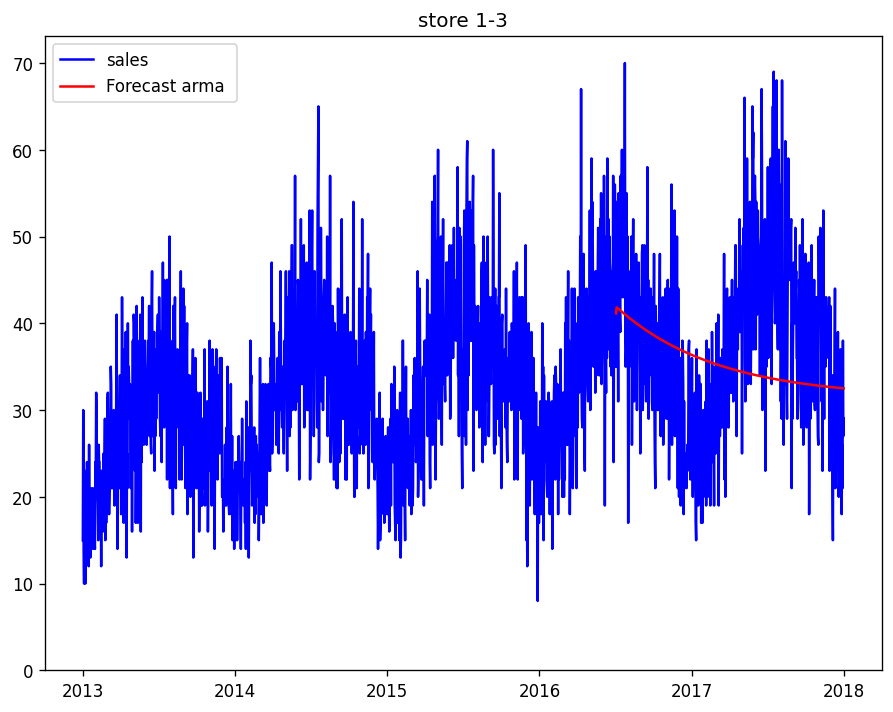

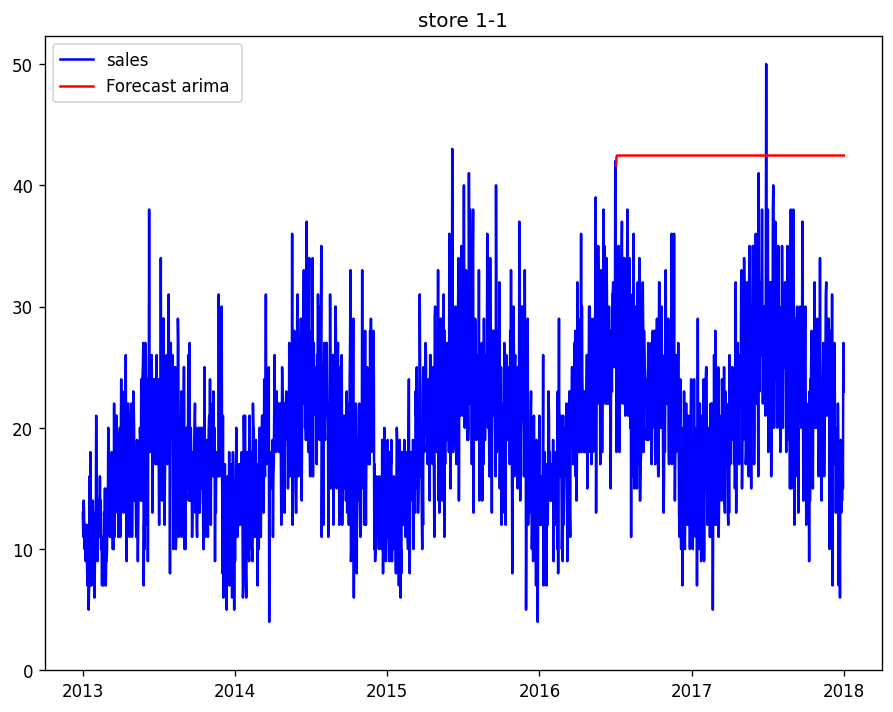

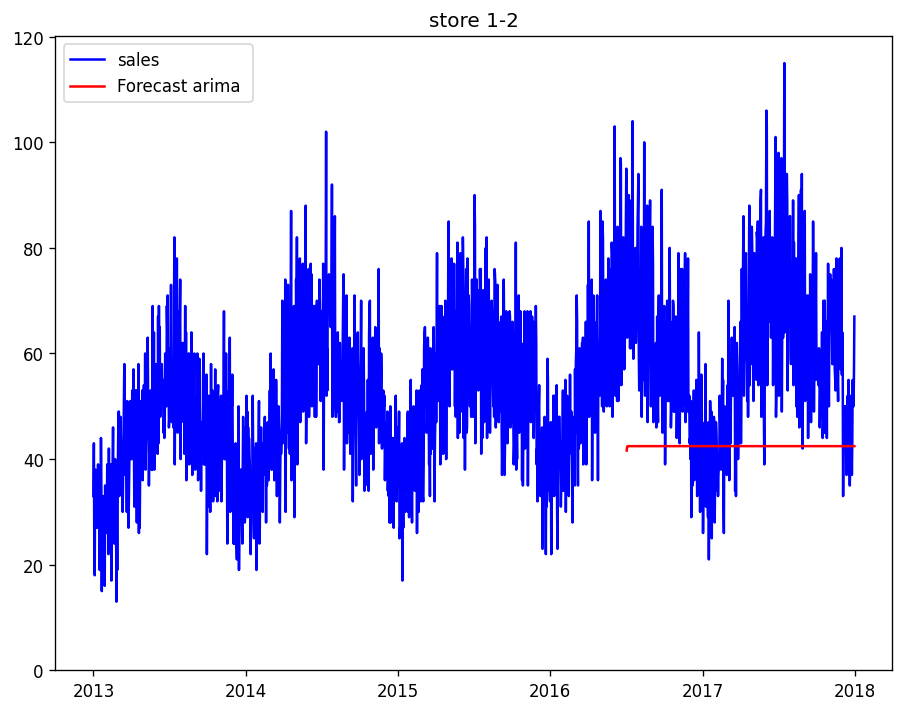

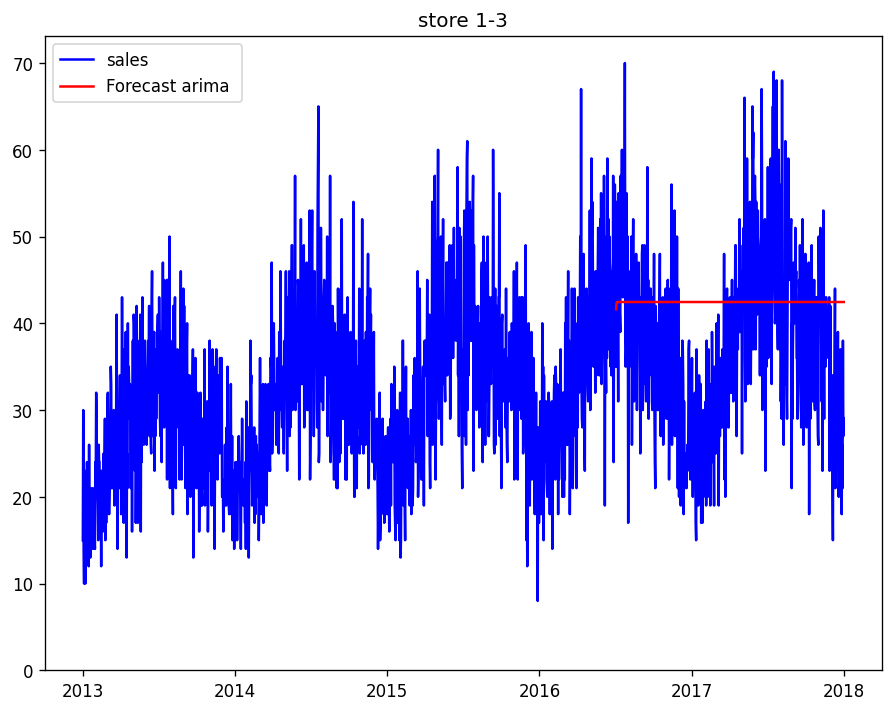

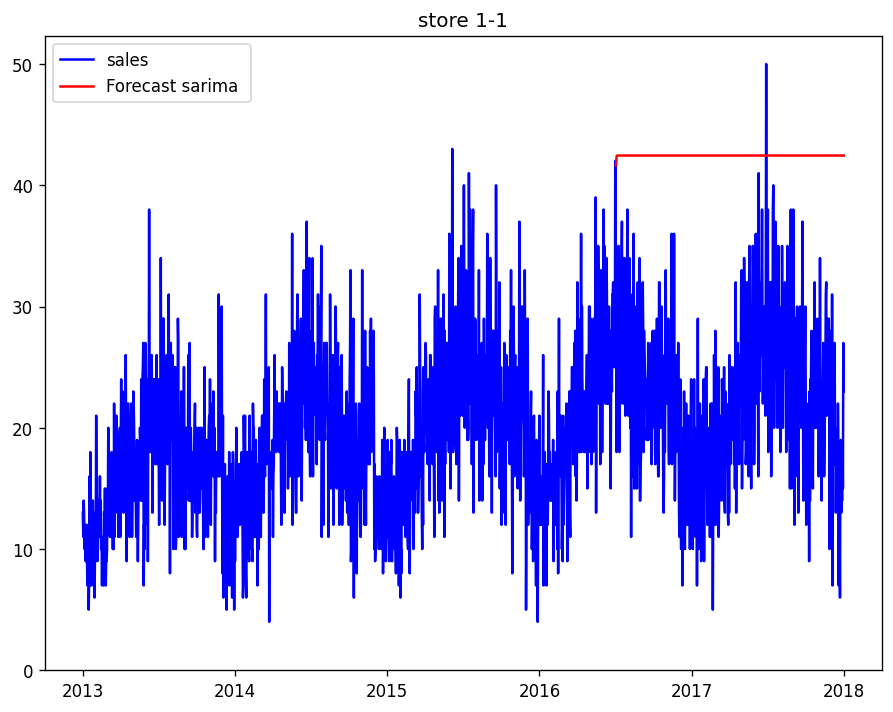

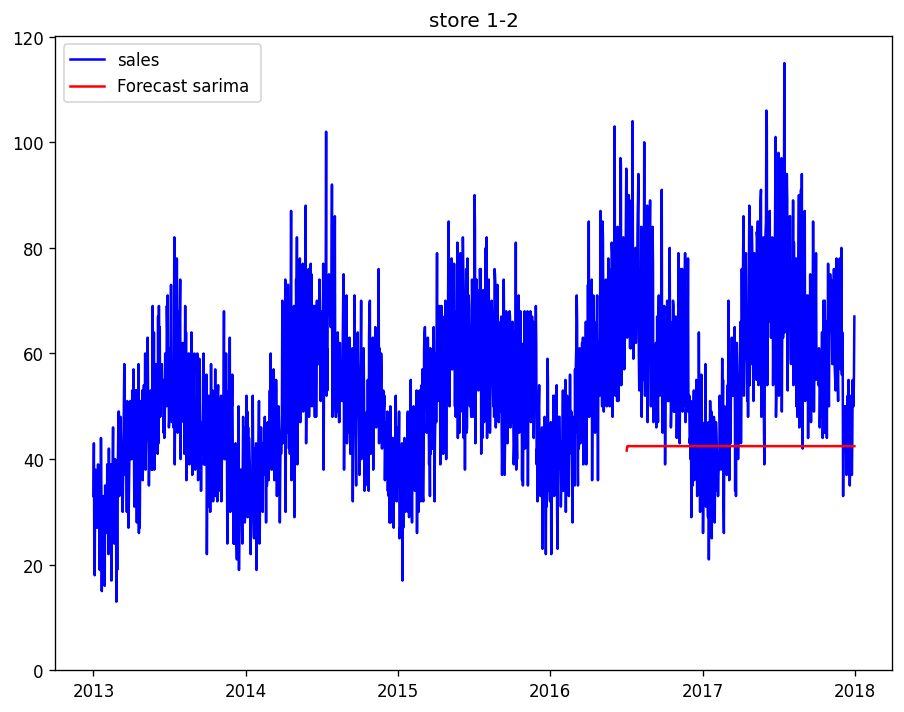

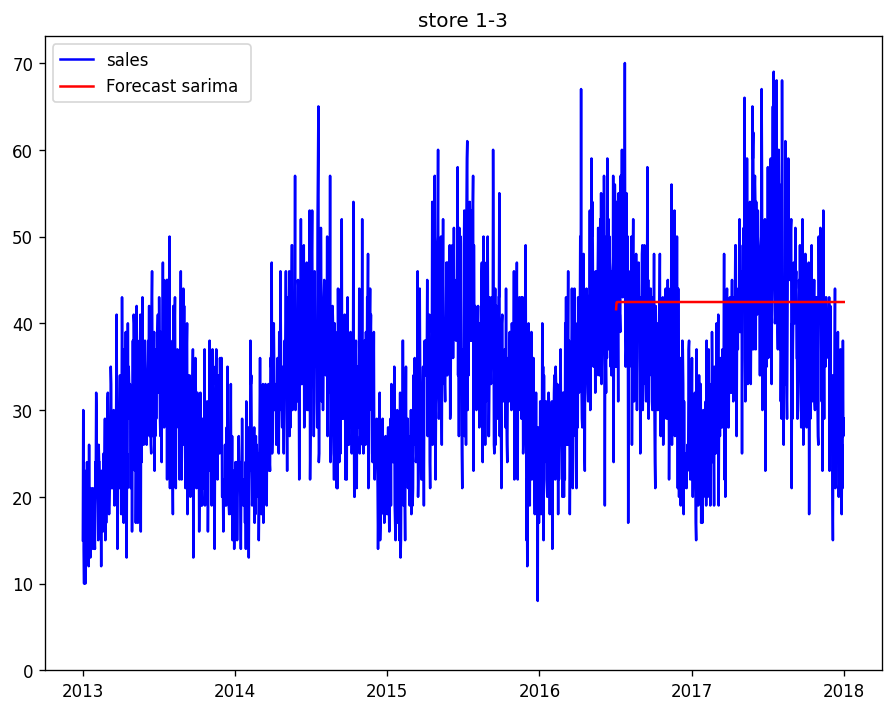

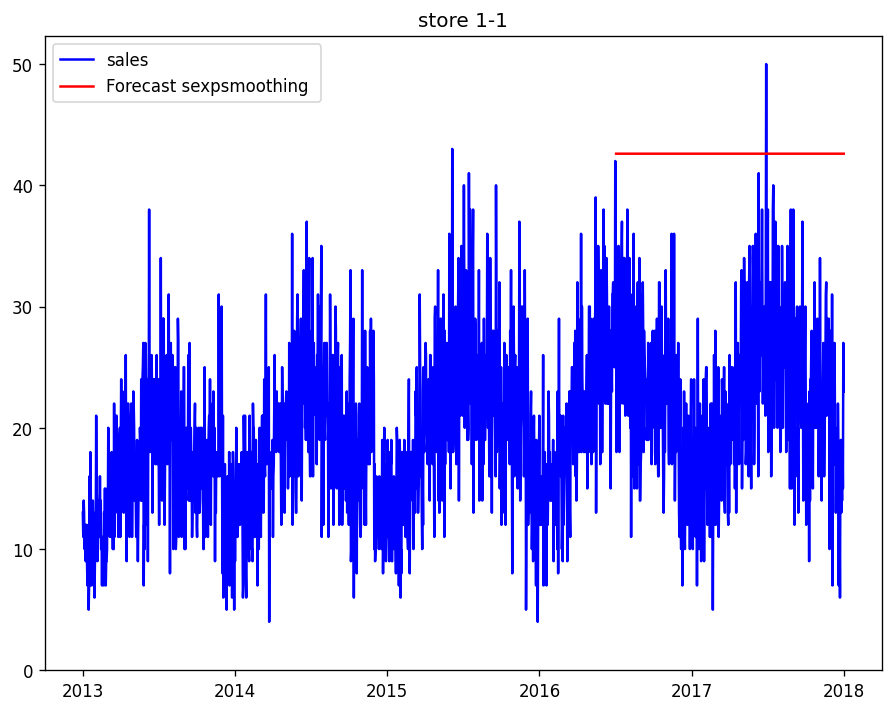

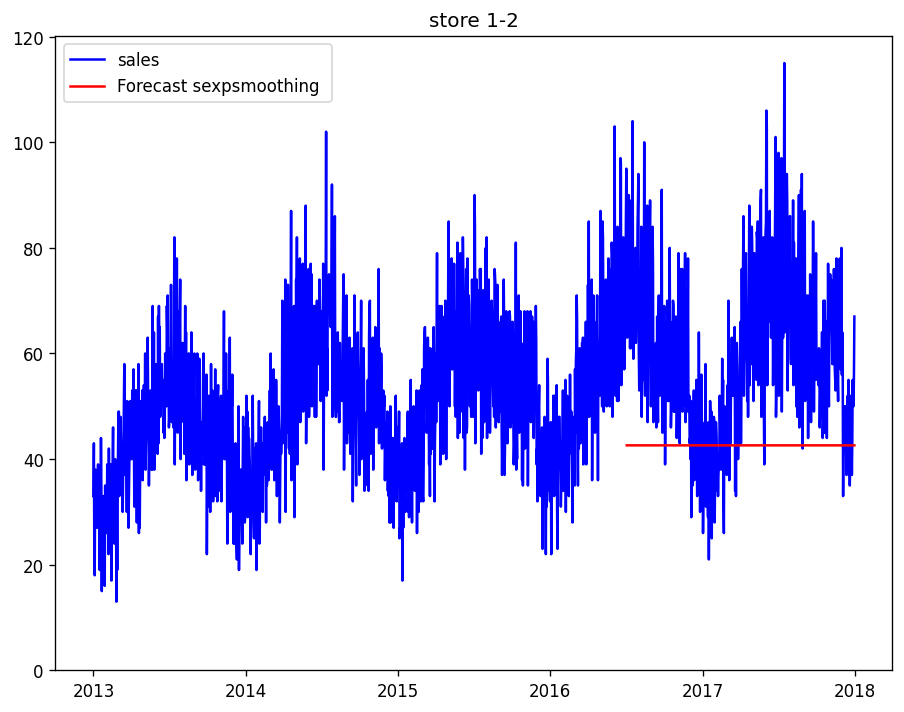

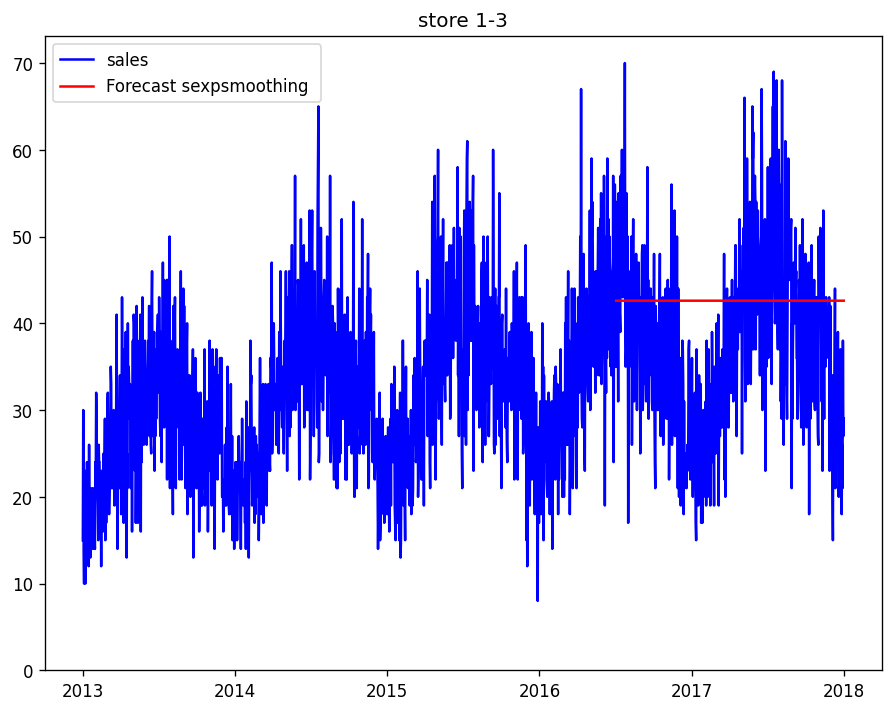

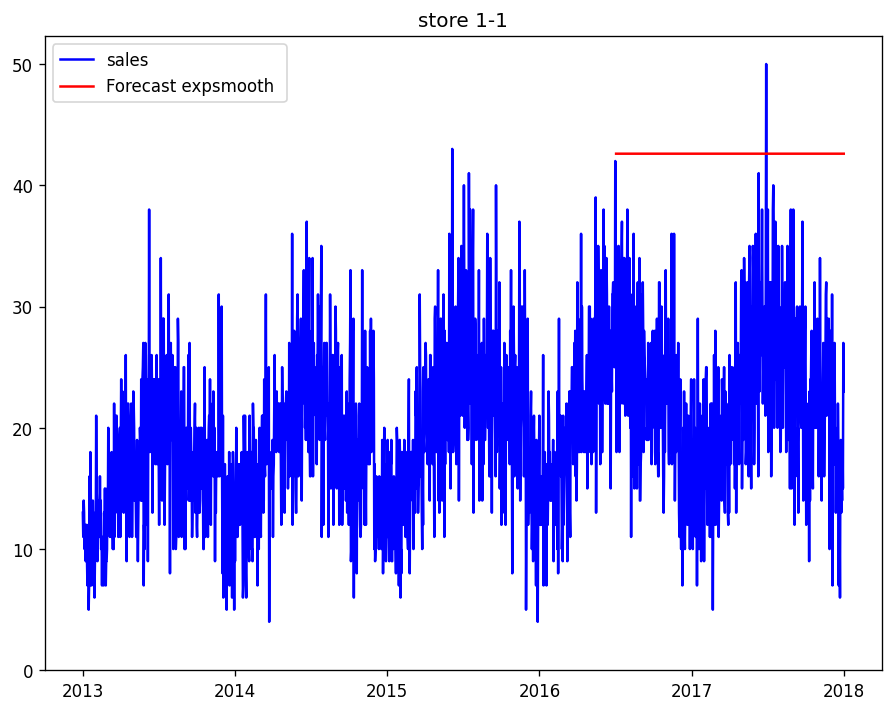

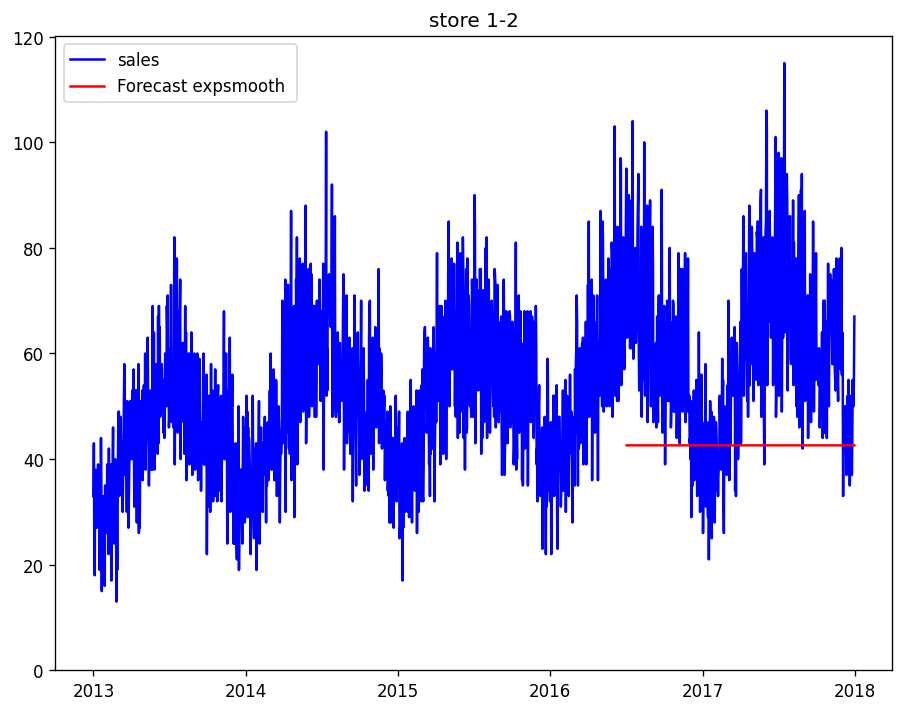

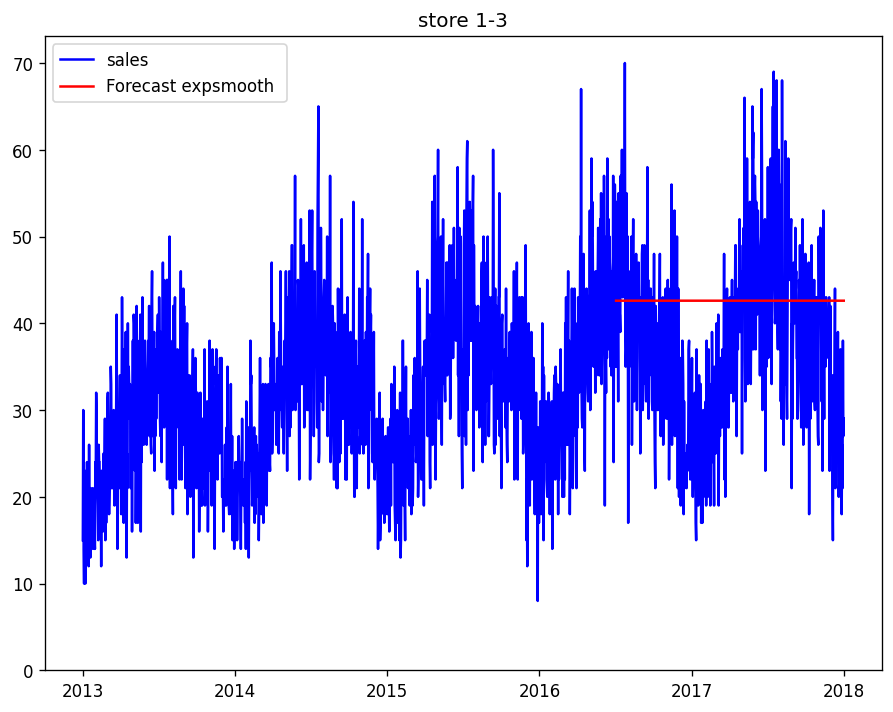

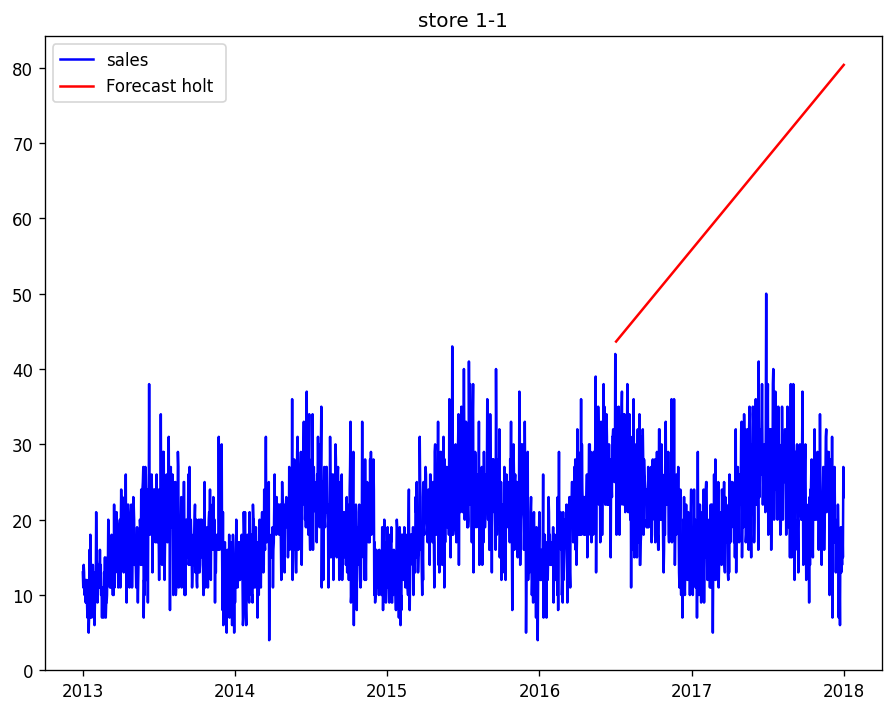

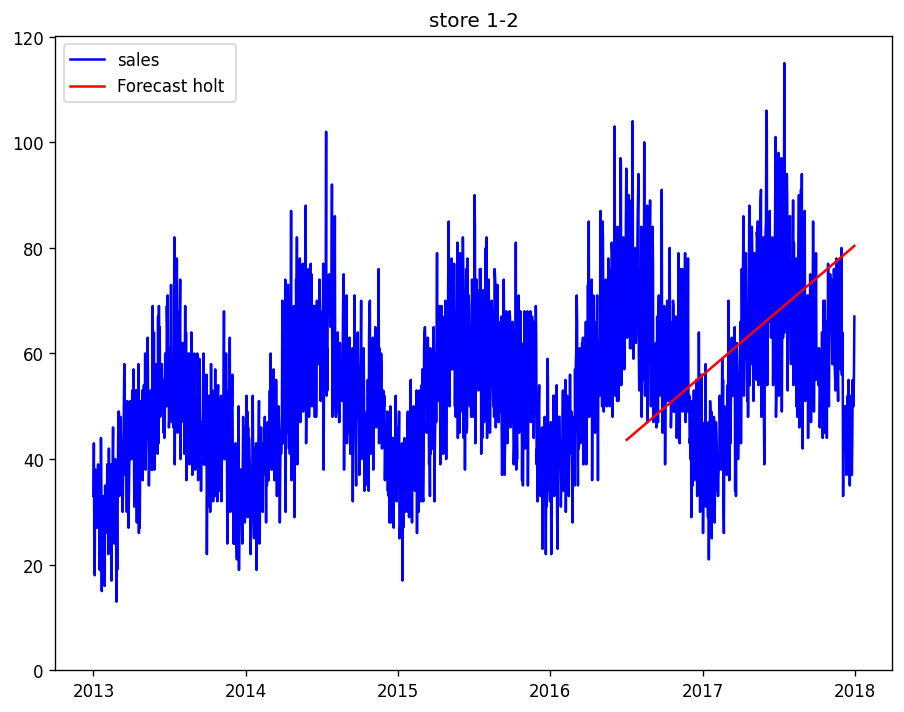

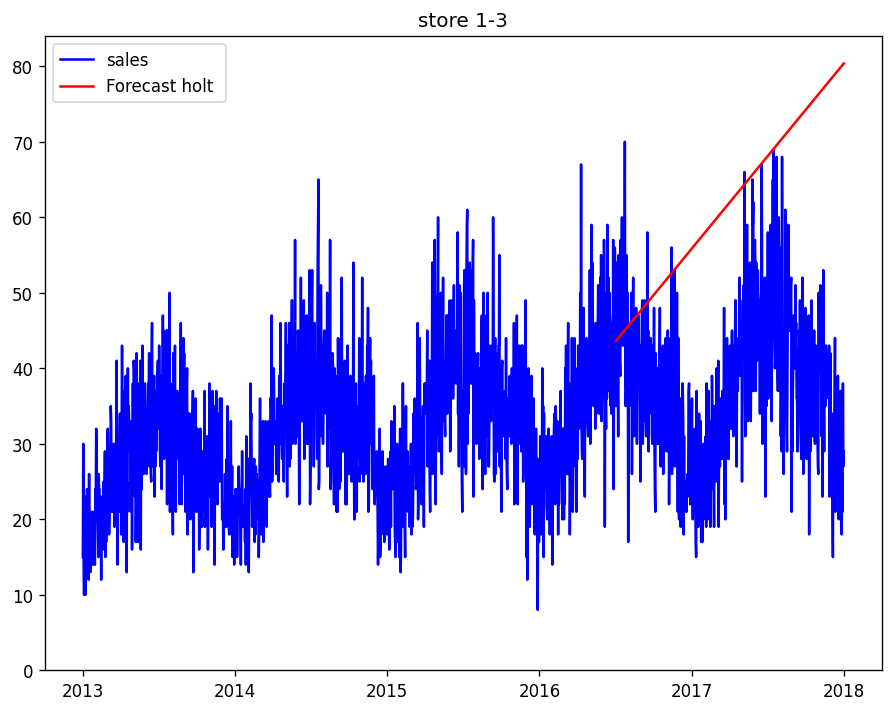

In [79]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

for forecast in store_sales.columns[2:]:
    fcastplotter(forecast)
